# Exploring Cached Presto Embeddings
This notebook queries the DuckDB cache at `embeddings_cache_LANDCOVER10.duckdb` and loads embeddings into pandas for inspection.

In [1]:
# Imports and path setup
import duckdb
import pandas as pd
from pathlib import Path
DB_PATH = Path('/home/vito/vtrichtk/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10.duckdb')
DB_PATH.exists()

True

In [2]:
# Open connection and list tables
con = duckdb.connect(str(DB_PATH))
con.execute('SHOW TABLES').fetchdf()

,name
0,embeddings_cache


In [3]:
# Basic row counts and distinct model hashes
summary_df = con.execute("""
SELECT model_hash,
       COUNT(*) AS n_rows,
       COUNT(DISTINCT sample_id) AS n_samples
FROM embeddings_cache
GROUP BY model_hash
ORDER BY n_rows DESC
""").fetchdf()
summary_df

,model_hash,n_rows,n_samples
0,9236078179d9268019190f3aa8ad6920927f766845ae0d...,8192,8192


In [4]:
# Preview first 5 rows (wide format)
preview_df = con.execute('SELECT * FROM embeddings_cache LIMIT 5').fetchdf()
preview_df.head()

,sample_id,model_hash,ref_id,ewoc_code,h3_l3_cell,lat,lon,embedding_0,embedding_1,embedding_2,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,2019_KEN_RadiantEarth-01_POLY_111_43,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2019_KEN_RadiantEarth-01_POLY_111,1101060000,837a4dfffffffff,0.537467,34.217770,-1.395690,-3.901479,1.592108,...,0.458443,-1.042760,-0.151641,0.973423,0.911437,0.785940,0.753711,0.281807,-1.916339,0.276480
1,2019_KEN_RadiantEarth-01_POLY_111_20,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2019_KEN_RadiantEarth-01_POLY_111,1107000040,837a4dfffffffff,0.538176,34.220177,-1.343452,-3.905180,1.513711,...,0.563504,-1.030388,-0.135688,0.958107,0.887937,0.734562,0.762983,0.214978,-1.937123,0.221704
2,2019_KEN_RadiantEarth-01_POLY_111_21,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2019_KEN_RadiantEarth-01_POLY_111,1101060000,837a4dfffffffff,0.538302,34.220074,-1.370493,-3.886128,1.530973,...,0.517984,-1.037232,-0.149809,0.976511,0.912368,0.737354,0.772359,0.236122,-1.920181,0.211436
3,2019_KEN_RadiantEarth-01_POLY_111_44,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2019_KEN_RadiantEarth-01_POLY_111,1107000040,837a4dfffffffff,0.538653,34.218010,-1.306327,-4.041270,1.505291,...,0.596890,-1.002163,-0.144140,0.901726,0.816242,0.730495,0.779550,0.188249,-1.900234,0.238002
4,2019_KEN_RadiantEarth-01_POLY_111_23,9236078179d9268019190f3aa8ad6920927f766845ae0d...,2019_KEN_RadiantEarth-01_POLY_111,1101060000,837a4dfffffffff,0.539091,34.220474,-1.298392,-3.968970,1.494113,...,0.553701,-1.008515,-0.169616,0.923368,0.849681,0.735604,0.675731,0.139085,-1.913811,0.216081


In [5]:
# Load a sample of embeddings as vectors (stack embedding_0..embedding_127)
sample_df = con.execute('SELECT * FROM embeddings_cache LIMIT 100').fetchdf()
embedding_cols = [c for c in sample_df.columns if c.startswith('embedding_')]
sample_df['embedding_vector'] = sample_df[embedding_cols].values.tolist()
sample_df[['sample_id','model_hash','embedding_vector']].head()

,sample_id,model_hash,embedding_vector
0,2019_KEN_RadiantEarth-01_POLY_111_43,9236078179d9268019190f3aa8ad6920927f766845ae0d...,"[-1.395690679550171, -3.9014790058135986, 1.59..."
1,2019_KEN_RadiantEarth-01_POLY_111_20,9236078179d9268019190f3aa8ad6920927f766845ae0d...,"[-1.343451738357544, -3.905179738998413, 1.513..."
2,2019_KEN_RadiantEarth-01_POLY_111_21,9236078179d9268019190f3aa8ad6920927f766845ae0d...,"[-1.3704925775527954, -3.8861286640167236, 1.5..."
3,2019_KEN_RadiantEarth-01_POLY_111_44,9236078179d9268019190f3aa8ad6920927f766845ae0d...,"[-1.3063263893127441, -4.041269779205322, 1.50..."
4,2019_KEN_RadiantEarth-01_POLY_111_23,9236078179d9268019190f3aa8ad6920927f766845ae0d...,"[-1.298391580581665, -3.9689698219299316, 1.49..."


In [6]:
# Compute mean embedding per model_hash (on a sample for speed)
# NOTE: Adjust LIMIT or remove it for full-table stats if memory permits.
df_sample = con.execute('SELECT * FROM embeddings_cache LIMIT 2000').fetchdf()
embedding_cols = [c for c in df_sample.columns if c.startswith('embedding_')]
mean_embeddings = df_sample.groupby('model_hash')[embedding_cols].mean()
mean_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
model_hash,,,,,,,,,,,,,,,,,,,,,
9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4,-1.246353,-4.16477,1.386378,-0.22145,-1.516973,1.418363,-1.143742,0.086673,0.717801,-1.818084,...,0.899509,-1.003972,-0.114867,1.034818,0.818181,0.684039,0.556464,-0.134863,-2.127345,0.205693


In [28]:
from worldcereal.utils.refdata import get_class_mappings
from worldcereal.utils.refdata import map_classes

CLASS_MAPPINGS = get_class_mappings()

SOURCE_PARQUET = '/projects/worldcereal/data/cached_wide_parquets/worldcereal_all_extractions_wide_month_LANDCOVER10.parquet'  # adjust if needed
df_src = pd.read_parquet(SOURCE_PARQUET, columns=['sample_id','ewoc_code'])
df_src = map_classes(df_src, 'LANDCOVER10', class_mappings=CLASS_MAPPINGS)
df_src.head()

2025-11-24 16:22:44.479 | WARNING  | worldcereal.utils.refdata:map_classes:118 - Some classes are missing in the mapping dictionary and thus will be removed: {'1402060000 - dry_pulses_with_trees': 19, '1101070020 - forage_sorghum': 180, '1403010000 - wheat_like_with_perennial': 33, '1402070000 - corn_with_trees': 1, '1402020000 - vegetables_with_trees': 35, '1114060050 - maize_mixed_with_grass': 1, '1402010000 - wheat_like_with_trees': 93, '2002030010 - cattail': 4, '2500000000 - non_cropland_mixed': 6391, '1402040000 - grass_with_trees': 3, '1114040010 - oilseeds_mixed_with_grass': 69, '1402080000 - oilseeds_with_trees': 10, '1401000000 - kitchen_allotment_gardens': 10145, '1403030000 - legumes_with_perennial': 7, '1402090000 - root_crops_with_trees': 10, '1400000000 - mixed_cropland': 57, '1403060000 - dry_pulses_with_perennial': 2, '1403020000 - vegetables_with_perennial': 10, '1114030030 - vegetables_mixed_with_grass': 41, '1114070000 - root_crops_mixed_with': 1, '1108020011 - wint

,sample_id,ewoc_code,finetune_class,balancing_class
0,2019_KEN_RadiantEarth-01_POLY_111_43,1101060000,temporary_crops,maize
1,2019_KEN_RadiantEarth-01_POLY_111_20,1107000040,temporary_crops,root_tuber_crops
2,2019_KEN_RadiantEarth-01_POLY_111_21,1101060000,temporary_crops,maize
3,2019_KEN_RadiantEarth-01_POLY_111_44,1107000040,temporary_crops,root_tuber_crops
4,2019_KEN_RadiantEarth-01_POLY_111_23,1101060000,temporary_crops,maize


In [ ]:
# Configuration for class embedding visualization (using raw ewoc_code)
EMB_DB = '/home/vito/vtrichtk/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10.duckdb'
SAMPLE_PER_CLASS = 300  # reduce/increase for speed vs fidelity
RANDOM_SEED = 42

import duckdb, pandas as pd, numpy as np, math, os, random
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# Load source labels (raw ewoc_code)
code_counts = df_src["finetune_class"].value_counts()

# Balanced sampling per ewoc_code
selected_ids = []
for code in code_counts.index.tolist():
    ids = df_src.loc[df_src.finetune_class==code,'sample_id']
    if len(ids) > SAMPLE_PER_CLASS:
        ids = ids.sample(SAMPLE_PER_CLASS, random_state=RANDOM_SEED)
    selected_ids.extend(ids.tolist())

print(f'Total sampled ids: {len(selected_ids)}')

con = duckdb.connect(EMB_DB)
con.register('sel_ids', pd.DataFrame({'sample_id': selected_ids}))
# Fetch embeddings for only selected ids
emb_cols = ', '.join([f'embedding_{i}' for i in range(128)])
query = f"""
SELECT e.sample_id, e.model_hash, {emb_cols}
FROM embeddings_cache e
INNER JOIN sel_ids USING(sample_id)
"""
emb_df = con.execute(query).fetchdf()

# Join ewoc_code labels
emb_df = emb_df.merge(df_src, on='sample_id', how='left')
print('Embeddings shape:', emb_df.shape)
emb_df.head()

Class counts:
 finetune_class
temporary_crops            2150546
grasslands                 1471387
temporary_grasses           327949
permanent_crops             282146
trees                       147014
shrubland                   105453
built_up                     99822
bare_sparsely_vegetated      73608
water                        54469
wetlands                      8650
Name: count, dtype: int64
Total sampled ids: 3000
Total sampled ids: 3000
Embeddings shape: (3000, 133)
Embeddings shape: (3000, 133)


,sample_id,model_hash,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,ewoc_code,finetune_class,balancing_class
0,2022_USA_USDA-CDL_POINT_110_847581,9236078179d9268019190f3aa8ad6920927f766845ae0d...,-1.181778,-4.011093,1.202260,0.266385,-1.427398,1.474534,-0.986094,0.578629,...,0.838264,0.372791,0.521455,0.085826,-0.570758,-1.776484,-0.110033,1100000000,temporary_crops,temporary_crops
1,2022_USA_USDA-CDL_POINT_110_1601809,9236078179d9268019190f3aa8ad6920927f766845ae0d...,-0.862045,-3.791258,1.047720,0.467673,-2.338732,1.598623,-1.299403,-0.173016,...,0.566989,0.158816,0.880701,1.012526,-0.006499,-1.718192,0.262300,1111000000,temporary_grasses,grass_fodder_crops
2,2022_USA_USDA-CDL_POINT_110_1880860,9236078179d9268019190f3aa8ad6920927f766845ae0d...,-1.009081,-3.846206,1.280926,0.536941,-1.769943,1.716758,-1.074275,0.044014,...,0.876790,0.393526,0.649058,0.239411,-0.576984,-1.762639,-0.152347,1101010002,temporary_crops,spring_wheat
3,2022_USA_USDA-CDL_POINT_110_1408817,9236078179d9268019190f3aa8ad6920927f766845ae0d...,-1.334127,-3.769466,1.243698,0.627938,-1.456152,1.918810,-1.047157,0.099799,...,0.982350,0.306069,0.497199,0.031177,-0.895861,-1.860809,-0.281810,1105000030,temporary_crops,dry_pulses_legumes
4,2022_USA_USDA-CDL_POINT_110_1141602,9236078179d9268019190f3aa8ad6920927f766845ae0d...,-0.989243,-4.163277,1.048411,0.272940,-1.544497,1.753230,-0.894311,0.454250,...,0.874074,0.665778,0.570744,0.083451,-0.653362,-1.816961,-0.132368,1108000010,temporary_crops,fibre_crops


In [35]:
# Prepare embedding matrix and labels (ewoc_code)
embedding_matrix = emb_df[[f'embedding_{i}' for i in range(128)]].to_numpy(dtype=np.float32)
labels = emb_df['finetune_class'].astype(str)
class_to_int = {c:i for i,c in enumerate(sorted(set(labels)))}
label_ids = np.array([class_to_int[l] for l in labels], dtype=np.int32)
print('Matrix shape:', embedding_matrix.shape, 'Num ewoc_codes:', len(class_to_int))

# Standardize (z-score) to equalize scale per dimension
mean = embedding_matrix.mean(axis=0, keepdims=True)
std = embedding_matrix.std(axis=0, keepdims=True) + 1e-6
emb_std = (embedding_matrix - mean) / std

Matrix shape: (3000, 128) Num ewoc_codes: 10


In [37]:
# PCA 2D & 3D projection (ewoc_code labeling)
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
pca3 = pca.fit_transform(emb_std)
pca2 = pca3[:, :2]

pca_df = pd.DataFrame({'pc1': pca2[:,0], 'pc2': pca2[:,1], 'finetune_class': labels})
pca3_df = pd.DataFrame({'pc1': pca3[:,0], 'pc2': pca3[:,1], 'pc3': pca3[:,2], 'ewoc_code': labels})
pca_df.head()

,pc1,pc2,finetune_class
0,1.468883,1.004032,temporary_crops
1,6.531188,-0.566146,temporary_grasses
2,1.291719,-0.108453,temporary_crops
3,0.163616,-2.615349,temporary_crops
4,2.538244,-0.887726,temporary_crops


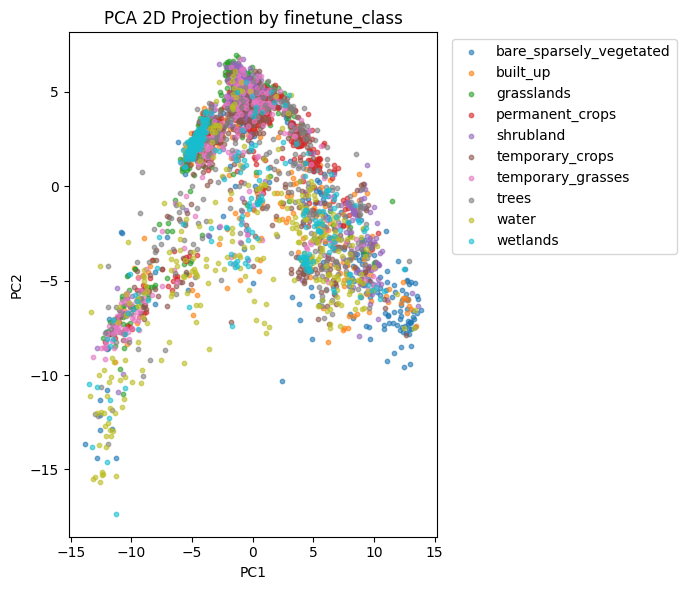

In [38]:
# 2D scatter plot (Matplotlib) of PCA by finetune_class
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
for code in sorted(class_to_int.keys()):
    mask = labels == code
    plt.scatter(pca_df.loc[mask,'pc1'], pca_df.loc[mask,'pc2'], s=10, alpha=0.6, label=code)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA 2D Projection by finetune_class')
plt.tight_layout()
plt.show()

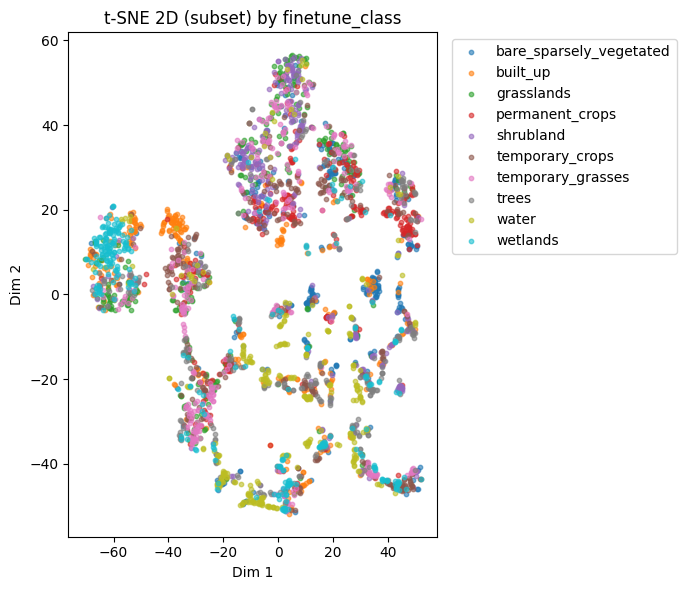

In [39]:
# Optional: t-SNE (subset) by finetune_class
from sklearn.manifold import TSNE
MAX_TSNE = 3000
idx = np.arange(len(emb_std))
if len(idx) > MAX_TSNE:
    idx = np.random.choice(idx, MAX_TSNE, replace=False)
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
tsne_coords = tsne.fit_transform(emb_std[idx])
tsne_labels = labels[idx]
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
for code in sorted(class_to_int.keys()):
    mask = tsne_labels == code
    plt.scatter(tsne_coords[mask,0], tsne_coords[mask,1], s=10, alpha=0.6, label=code)
plt.title('t-SNE 2D (subset) by finetune_class')
plt.xlabel('Dim 1'); plt.ylabel('Dim 2'); plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()


In [40]:
# Cluster quality metrics using ewoc_code
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
X_cluster = pca2  # reduced 2D
k = len(class_to_int)
km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_cluster)
sil = silhouette_score(X_cluster, km.labels_)
print(f'Silhouette score (k={k}): {sil:.4f}')
# Distance to ewoc_code mean in standardized space
code_means = {code: emb_std[labels==code].mean(0) for code in class_to_int.keys()}
per_sample_dist = np.empty(len(emb_std), dtype=np.float32)
for i, code in enumerate(labels):
    per_sample_dist[i] = np.linalg.norm(emb_std[i] - code_means[code])
dist_df = pd.DataFrame({'sample_id': emb_df.sample_id, 'ewoc_code': labels, 'dist_to_code_mean': per_sample_dist})
print(dist_df.head())
print('Per-code mean distance (lower => tighter cluster):')
print(dist_df.groupby('ewoc_code')['dist_to_code_mean'].mean().sort_values())

Silhouette score (k=10): 0.4160
                             sample_id          ewoc_code  dist_to_code_mean
0   2022_USA_USDA-CDL_POINT_110_847581    temporary_crops           7.071227
1  2022_USA_USDA-CDL_POINT_110_1601809  temporary_grasses          15.519013
2  2022_USA_USDA-CDL_POINT_110_1880860    temporary_crops           6.566576
3  2022_USA_USDA-CDL_POINT_110_1408817    temporary_crops           8.423043
4  2022_USA_USDA-CDL_POINT_110_1141602    temporary_crops           7.506588
Per-code mean distance (lower => tighter cluster):
ewoc_code
permanent_crops             7.556878
grasslands                  7.708878
temporary_grasses           9.139031
wetlands                    9.148675
shrubland                   9.185668
temporary_crops             9.377655
built_up                    9.470347
trees                      11.275585
bare_sparsely_vegetated    12.327095
water                      13.204353
Name: dist_to_code_mean, dtype: float32


In [43]:
# UMAP 2D projection (subset for speed)
UMAP_MAX = 8000  # tune for performance

import umap

umap_idx = np.arange(len(emb_std))
if len(umap_idx) > UMAP_MAX:
    umap_idx = np.random.choice(umap_idx, UMAP_MAX, replace=False)
X_umap = emb_std[umap_idx]
labels_umap = labels[umap_idx]
print('Running UMAP on', X_umap.shape)
reducer = umap.UMAP(n_components=2, random_state=42, metric='euclidean', n_neighbors=30, min_dist=0.15)
umap_coords = reducer.fit_transform(X_umap)

umap_df = pd.DataFrame({'u1': umap_coords[:,0], 'u2': umap_coords[:,1], 'finetune_class': labels_umap})
umap_df.head()

Running UMAP on (3000, 128)


/home/vito/vtrichtk/miniconda3/envs/worldcereal/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



,u1,u2,finetune_class
0,58.329597,23.608908,temporary_crops
1,57.541447,22.969398,temporary_grasses
2,57.740257,24.101599,temporary_crops
3,57.601673,24.706917,temporary_crops
4,58.517456,23.408619,temporary_crops


In [44]:
# Interactive Plotly scatter for UMAP
import plotly.express as px

color_count = umap_df['finetune_class'].nunique()
# If too many classes, show top frequent and bucket others as 'OTHER'
MAX_LEGEND = 30
if color_count > MAX_LEGEND:
    top_codes = umap_df['finetune_class'].value_counts().head(MAX_LEGEND).index
    umap_df['finetune_class_plot'] = np.where(umap_df['finetune_class'].isin(top_codes), umap_df['finetune_class'], 'OTHER')
else:
    umap_df['finetune_class_plot'] = umap_df['finetune_class']

fig = px.scatter(
    umap_df,
    x='u1', y='u2',
    color='finetune_class_plot',
    hover_data={'finetune_class': True, 'u1': ':.3f', 'u2': ':.3f'},
    title=f'UMAP projection ({len(umap_df)} samples)'
)
fig.update_layout(legend=dict(itemsizing='trace', title='finetune_class'))
fig.show()